# Update of Demonstration
## Dataset Preparation & Loading Packages
### Create [NDMI](https://www.usgs.gov/landsat-missions/normalized-difference-moisture-index) Masked by [a Boundary Layer](https://data.humdata.org/dataset/cod-ab-bra)
The Python codes below shows how to
1. Reproject raster using PROJ4
2. Mask raster by a shapefile
3. Calculate NDMI, which is "[calculated as a ratio between the NIR and SWIR values in traditional fashion.](https://www.usgs.gov/landsat-missions/normalized-difference-moisture-index)" 

We used the following dataset with these ID.
- 2016 Dataset: LC08_L2SP_220068_20160730_20200906_02_T1
    - Landsat8 Level2  Tier 1 Surface Reflectance Data. 
- 2021 Dataset: LC08_L2SP_220068_20210728_20210804_02_T1
    - Landsat8 Level2 Tier1 Surface Reflectance Data 
    - The image was taken 30 Jul, 2016

In [1]:
# IMPORT LIBRARIES####
import rasterio as rio 
import rasterio.mask as msk
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.enums import Resampling

import geopandas as gpd 

import numpy as np
import pandas as pd
import json
import os

In [2]:
# REPROJECT RASTER TO UTM 23S####
def reprojectRaster(inPath, 
                    outPath,
                    outCrs,
                    categorical = False):
    
    if categorical == True:
       how2Resample = Resampling.nearest
    else:
        how2Resample = Resampling.bilinear
   
    # Open the Input Raster====
    with rio.open(inPath) as src:
       # Calculate Output Meta Data====
       outTrans, outW, outH = rio.warp.calculate_default_transform(
           src.crs, outCrs, src.width, src.height, *src.bounds
       )

       # Update Output Meta Data====
       profile = src.profile.copy()
       profile.update({
           'crs': outCrs,
           'transform': outTrans,
           'width': outW,
           'height': outH,
           "nodata": 0
       })

       # Write Data with Reprojection====
       with rio.open(outPath, 'w', **profile) as dst:
           rio.warp.reproject(
               source = rio.band(src, 1),
               destination = rio.band(dst, 1),
               src_transform = src.transform,
               src_crs = src.crs,
               dst_transform = outTrans,
               dst_crs = outCrs,
               resampling = how2Resample  # You can choose a different resampling method if needed
           )

In [3]:
reprojectRaster("LC08_L2SP_220068_20160730_20200906_02_T1_SR_B5.TIF",
                "b52016reproj.tif",
                "+proj=utm +zone=23 +south +datum=WGS84 +units=m +no_defs +type=crs")

In [4]:
reprojectRaster("LC08_L2SP_220068_20160730_20200906_02_T1_SR_B6.TIF",
                "b62016reproj.tif",
                "+proj=utm +zone=23 +south +datum=WGS84 +units=m +no_defs +type=crs")

In [5]:
reprojectRaster("LC08_L2SP_220068_20210728_20210804_02_T1_SR_B5.TIF",
                "b52021reproj.tif",
                "+proj=utm +zone=23 +south +datum=WGS84 +units=m +no_defs +type=crs")

In [6]:
reprojectRaster("LC08_L2SP_220068_20210728_20210804_02_T1_SR_B6.TIF",
                "b62021reproj.tif",
                "+proj=utm +zone=23 +south +datum=WGS84 +units=m +no_defs +type=crs")

In [7]:
# GET BOUDNARY OF RASTE BY SHAPE OF THE MUNICIPALITY####
def changeShpToJson(pathToBoundary,
                    pathToRaster):
    
    # Open File and Dissolve it====
    g = gpd.read_file(pathToBoundary).dissolve()

    # Open Raster File====
    r = rio.open(pathToRaster)

    # Align CRS====    
    if g.crs != r.crs:
        g = g.to_crs(r.crs)

    # Convert Geopandas Geometry to Json====
    return [json.loads(g.to_json())["features"][0]["geometry"]]

In [8]:
# Apply Function====
coords = changeShpToJson("richaoDasNeves.geojson",
                         "b62021reproj.tif")

In [9]:
# MASK RASTER BY FEATURE####
def maskRaster(pathToRaster,
               boundary,
               outPath):
    # Open File====
    r = rio.open(pathToRaster)

    # Mask Raster by the JSON Feature====
    outImg, outTrans = msk.mask(r,
                                shapes = boundary,
                                crop = True)
    
    # Updating Meta====
    outMeta = r.meta.copy()
    outMeta.update({
        "dirver": "GTiff",
        "height": outImg.shape[1],
        "width": outImg.shape[2],
        "transform": outTrans,
        "count": 1,
        "nodata": 0,
        "datatype": np.uint32,
        "crs": r.crs
    })

    # Write File====
    with rio.open(outPath, 
                  "w",
                  **outMeta) as outfile:
        outfile.write(outImg)

In [10]:
maskRaster("b52016reproj.tif",
           coords,
           "b52016msk.tif")

In [11]:
maskRaster("b62016reproj.tif",
           coords,
           "b62016msk.tif")

In [12]:
maskRaster("b52021reproj.tif",
           coords,
           "b52021msk.tif")

In [13]:
maskRaster("b62021reproj.tif",
           coords,
           "b62021msk.tif")

In [14]:
# CALCULATE NDMI#####
def calculateNDMI(b5Path,
                  b6Path,
                  outPath):
    
    # Open File====
    b5 = rio.open(b5Path)
    b6 = rio.open(b6Path)

    # Read as Array====
    b5arr = b5.read(1).astype("float32")
    b6arr = b6.read(1).astype("float32")

    # Calculate NDMI and Place 0 if Out of Boundary====
    outarr = np.where(b5arr + b6arr == 0,
                      0,
                      (b5arr - b6arr)/ (b5arr + b6arr))
    

    # Updating Meta====
    outMeta = b5.meta.copy()
    outMeta.update({
        "dirver": "GTiff",
        "height": b5.height,
        "width": b5.width,
        "transform": b5.transform,
        "nodata": np.nan,
        "dtype": np.float32,
        "crs": b5.crs
    })

    # Write File====
    with rio.open(outPath, 
                  "w",
                  **outMeta) as outfile:
        outfile.write(outarr, 1)

In [15]:
# Apply Function=====
calculateNDMI("b52016msk.tif",
              "b62016msk.tif",
              "ndmi2016.tif")

/var/folders/fj/5v0w95fn2cg7z3jtwpv6ldpw0000gn/T/ipykernel_11334/1737056106.py:17: RuntimeWarning: invalid value encountered in divide
  (b5arr - b6arr)/ (b5arr + b6arr))


In [16]:
calculateNDMI("b52021msk.tif",
              "b62021msk.tif",
              "ndmi2021.tif")

/var/folders/fj/5v0w95fn2cg7z3jtwpv6ldpw0000gn/T/ipykernel_11334/1737056106.py:17: RuntimeWarning: invalid value encountered in divide
  (b5arr - b6arr)/ (b5arr + b6arr))


### Resample [Irrigation Data](https://brasil.mapbiomas.org/en/) and Mask the Layer
We downloaded irrigation data at 2016 and 2021 (5 years). The data was derived from MapBiomas Brazil. 
The below code shows how to
1. Reproject raster
2. Mask raster
3. Resample raster layers to the NDMI layers.

In [17]:
# REPROJECT RASTER####
reprojectRaster("irrigation_2016.tif",
                "irrigation2016_reproj.tif",
                "+proj=utm +zone=23 +south +datum=WGS84 +units=m +no_defs +type=crs",
                categorical = True)

In [18]:
reprojectRaster("irrigation_2021.tif",
                "irrigation2021_reproj.tif",
                "+proj=utm +zone=23 +south +datum=WGS84 +units=m +no_defs +type=crs",
                categorical = True)

In [19]:
# MASK RASTER####
maskRaster("irrigation2016_reproj.tif",
           coords,
           "irrigation2016_masked.tif")

In [20]:
maskRaster("irrigation2021_reproj.tif",
           coords,
           "irrigation2021_masked.tif")

In [21]:
# ALIGN RASTER TO NDMI####
def resampleRaster(modifiedFile,
                   targetFile,
                   outPath):
    
    with rio.open(modifiedFile) as src:
        with rio.open(targetFile) as dst:
        # Define Transformation Parameters====
            outTrans, outWidth, outHeight = calculate_default_transform(
                src.crs,
                dst.crs,
                dst.width,
                dst.height,
                *dst.bounds
            )
        
        # Get Meta Information and OverWrite====
        outMeta = src.meta.copy()
        outMeta.update({
            "crs": dst.crs,
            "transform": outTrans,
            "width": outWidth,
            "height": outHeight,
            "nodata": 0
        })

        # Write Data with Assigning Meta====
        with rio.open(outPath,
                      "w",
                      **outMeta) as r:
            # Write file by reprojecting every band----
            for i in range(1, src.count + 1):
                reproject(
                    source = rio.band(src, i),
                    destination = rio.band(r, i),
                    src_transform = src.transform,
                    src_crs = src.crs,
                    dst_transform = outTrans,
                    dst_crs = dst.crs,
                    resampling = Resampling.nearest
                )

        # Modify Raster so that the Raster is Binary====
        r = rio.open(outPath)
        arr = r.read(1)

        # Create an Array of Presence and Absence====
        outarr = arr.copy()
        outarr[(arr > 0)] = 1
        outarr[(arr == 0)] = 0



        # Updating Meta====
        outMeta = r.meta.copy()
        outMeta.update({
            "dirver": "GTiff",
            "height": r.height,
            "width": r.width,
            "transform": r.transform,
            "nodata": 0,
            "dtype": np.uint8,
            "crs": r.crs
        })

        # Write File====
        with rio.open(outPath, 
                    "w",
                    **outMeta) as outfile:
            outfile.write(outarr, 1)

In [22]:
resampleRaster("irrigation2016_masked.tif",
               "ndmi2016.tif",
               "irr2016_resample.tif")

In [23]:
resampleRaster("irrigation2021_masked.tif",
               "ndmi2016.tif",
               "irr2021_resample.tif")

## Calculate Interval Metrics
This section calculates 4 metrics that Pontius Jr. (2022) suggested, which are mean deviation, mean absolute deviation, correlation, and slope.

In [24]:
# IMPORT ADDITIONAL PACKAGES####
from scipy.stats import linregress
import matplotlib as mpl 
import matplotlib.pyplot as plt 

In [25]:
# READ FILES####
x = rio.open("ndmi2016.tif").read(1)
y = rio.open("ndmi2021.tif").read(1)

X = x[(x + y != 0)]
Y = y[(x + y != 0)]


# Calculate Deviation====
d = y - x
D = Y - X

In [26]:
# CALUCULATE METRICS####
# Calculate Mean X and Mean Y====
meanX = X.mean()
meanY = Y.mean()

print("Mean X and Y")
print(meanX)
print(meanY)
# Calculate Mean Deviation====
md = meanY - meanX
print("Mean Deviation: ", md)

# Calculate Mean Absolute Deviation====
mad = np.absolute(D).mean()
print("Mean Absolute Deviation: ", mad)

# Calculate Correlation & Slope====
lmResult = linregress(X, Y)
print("Correlation: ", lmResult.rvalue)
print("Slope: ", lmResult.slope)

Mean X and Y
-0.03985505
-0.026396563
Mean Deviation:  0.0134584885
Mean Absolute Deviation:  0.039217718
Correlation:  0.5878457574078635
Slope:  0.6689676455364478


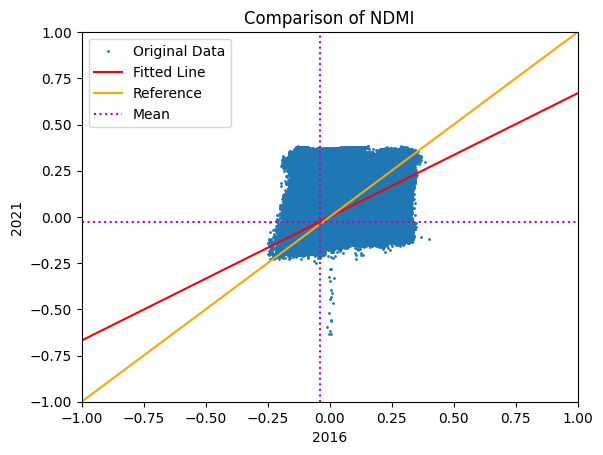

In [27]:
# PLOT DATA ON A SCATTER PLOT####
# Define Data and Dots' Shapes====
plt.plot(X, 
         Y, 
         "o", 
         # Define label----
         label = "Original Data", 
         markersize = 1)

# Define X Limits and Y Limits so that They Have the Same Scale and Bounds====
xLim = [-1, 1]
yLim = [-1, 1]

# Plot Least Square Line====
# Define x limits of line----
plt.plot(xLim, 
         # Define minimum y: multiply -1 by slope and add intercept----
         [lmResult.intercept + lmResult.slope*xLim[0], 
         # Define maximum y: multiply 1 by slope and add intercept
          lmResult.intercept + lmResult.slope*xLim[1]], 
         # Define color----
         "r", 
         # Define 
         label = "Fitted Line")

# Plot 1:1 Line====
plt.plot(xLim, 
         yLim, 
         "orange", 
         label = "Reference")

# Plot X Mean Line====
plt.plot([meanX, meanX], 
         yLim, 
         # Use dotted line of magenta----
         "m:", 
         label = "Mean")

# Plot Y Mean Line====
plt.plot(xLim, 
         [meanY, meanY],
         "m:")

# Define Other Properties====
plt.title("Comparison of NDMI")
plt.xlabel("2016")
plt.ylabel("2021")
plt.xlim(xLim)
plt.ylim(yLim)
plt.plot()
plt.legend()
plt.show()

## Reclassify Raster
This section represents two new methods to reclassify the values at two time points, focusing on
- Mean values both at the 1st and the 2nd time point
- MAD that will filter out pixels with smaller deviations.

### Quadrant Reclassification

In [28]:
# READ FILE####
x = rio.open("ndmi2016.tif").read(1)
y = rio.open("ndmi2021.tif").read(1)


# RECLASSIFY VALUES####
q = x.copy()

# Note Quadrants and Values do not Necessarily Match Because of the Ranking of Assumption====
q[(x > meanX) & (y > meanY)] = 3
q[(x <= meanX) & (y > meanY)] = 1
q[(x <= meanX) & (y <= meanY)] = 2
q[(x > meanX) & (y <= meanY)] = 4

q[(x + y == 0)] = 0
print(q.shape)


# EXPORT FILE####
# Get Meta====
rst = rio.open("ndmi2016.tif")
outMeta = rst.meta.copy()
outMeta.update({
    "dirver": "GTiff",
    "height": rst.height,
    "width": rst.width,
    "transform": rst.transform,
    "nodata": 0,
    "dtype": "uint8",
    "crs": rst.crs
    })

with rio.open("quadrant.tif",
              "w",
              **outMeta) as newr:
    newr.write(q, 1)

(2484, 5347)


### MAD Reclassification
1. Positive Deviation > MAD
2. Negative Deviation > MAD * -1
3. Absolute Deviation < MAD

In [29]:
# CREATE DEVIATION ARRAY####
# Keep Nan Values====
d = y - x
m = d.copy()

# RECLASSIFY VALUES####
m[(d > mad)] = 1
m[(d < -1* mad)] = 2
m[(np.absolute(d) < mad)] = 3
q[(x + y == 0)] = 0


# EXPORT DEVIATION & MAD RASTER####
with rio.open("mad.tif",
              "w",
              **outMeta) as newr:
    newr.write(m, 1)

with rio.open("deviation.tif",
              "w",
              **outMeta) as newr:
    newr.write(d, 1)

## Check Association of the Irrigation Gain and the Reclassification using TOC curve
The TOC curve represents an associatoin between a ranked variables and presence of a phenomena.
We used the following layers, in addition to the reclassified variables.
- Boolean: Irrigation Gain during the Time Interval of 2016 and 2021 = Irrigation2021 - Irrigation2016
- Study Extent: The Municipality - Irrigation Presence at 2016

Our assumption is the presence of irrigation gains are associated with the quadrant reclassification presences in the following order.
1. 2nd quadrant
2. 3rd quadrant
3. 1st quadrant
4. 4th quadrant

Our assumption is the presence of irrigation gains are associated with the MAD reclassification presences in the following order.
1. Positive deviations larger than MAD.
2. Negative deviations larger than MAD* (-1).
3. Smaller absolute deviations than MAD.

Finally, we combined these rasters, and the presence of irrigation gains are associated with the final reclassification presences in the following order.
1. 2nd quadrant + Positive deviations larger than MAD.
2. 3rd quadrant + Positive deviations larger than MAD.
3. 1st quadrant + Positive deviations larger than MAD.

In [30]:
# CREATE BOOLEAN RASTER####
irr2016 = rio.open("irr2016_resample.tif").read(1)
irr2021 = rio.open("irr2021_resample.tif").read(1)
gain = np.where(irr2021 - irr2016 != 1,
                0,
                1)

# CREATE STUDY EXTENT RASTER####
# Distinguish Inside and Outside of Boundary====
ext = np.where((x + y) != 0,
               1,
               0)

# Insert 0 if Irrigation Exist at 2016====
ext[(irr2016 == 1)] = 0

# Export Rasters====
with rio.open("gain.tif",
              "w",
              **outMeta) as newr:
    newr.write(gain, 1)

with rio.open("ext.tif",
              "w",
              **outMeta) as newr:
    newr.write(ext, 1)

The size of extent: 13281948
Abundance: 71718
AUC: 0.9500782513750314
The coordinate of point below top left corner: (71718,7407.183355698165)
None


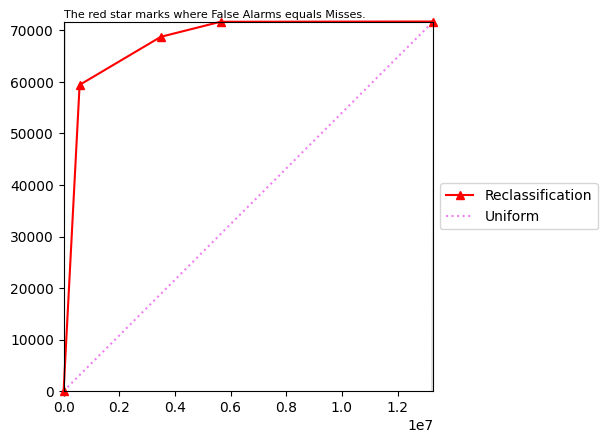

In [31]:
# EXAMINE QUADRANT RASTER####
# Run TOC====
from pytoc import TOC
from pytoc import TOC_painter

ext = rio.open("ext.tif").read(1)
toc1 = TOC(gain, q, range(1, 4), maskArray = ext)

# Print AUC====
print(toc1.summary())

# Draw TOC Curve
painter = TOC_painter(TOC_list=[toc1], 
                      index_names=["Reclassification"], 
                      color_list=["r"], 
                      marker_list=["^"], 
                      line_list=["-"], 
                      boolUniform=True, 
                      boolCorrectCorner=True)
painter.paint()

The size of extent: 13281948
Abundance: 71718
AUC: 0.9256256041378782
The coordinate of point below top left corner: (71718,3988.2281709304607)
None


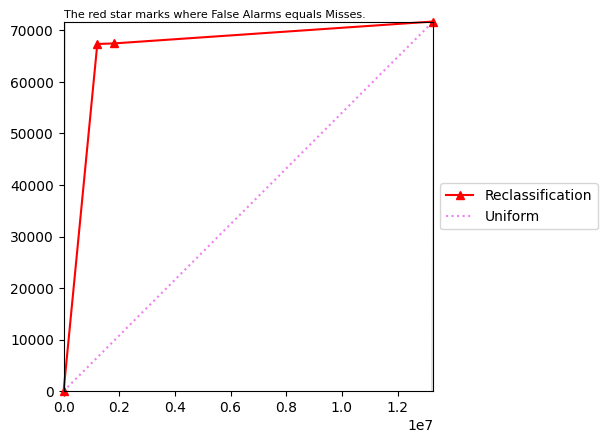

In [32]:
# EXAMINE MAD RASTER####
ext = rio.open("ext.tif").read(1)
toc2 = TOC(gain, m, range(1, 3), maskArray = ext)


# Print AUC====
print(toc2.summary())

# Draw TOC Curve====
painter = TOC_painter(TOC_list=[toc2], 
                      index_names=["Reclassification"], 
                      color_list=["r"], 
                      marker_list=["^"], 
                      line_list=["-"], 
                      boolUniform=True, 
                      boolCorrectCorner=True)
painter.paint()

The size of extent: 13281948
Abundance: 71718
AUC: 0.9457898002623933
The coordinate of point below top left corner: (71718,8163.753875452879)
None


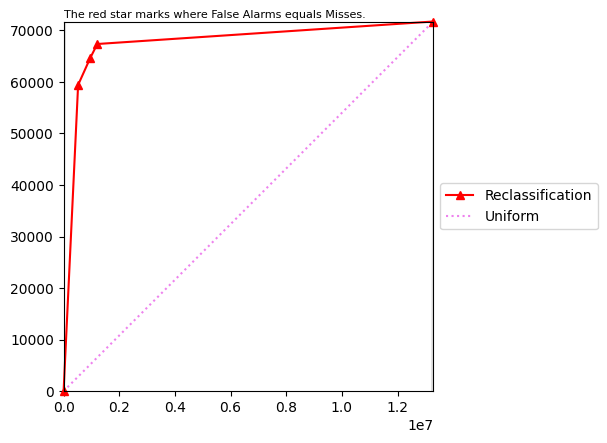

In [33]:
# COMBINE MAD AND QUADRANT####
# Reclassify pixels to 1: Positive Association > MAD + 2nd Quadrant====
combinedarr = x.copy()
combinedarr[~np.isnan(combinedarr)] = 0
combinedarr[(q == 1) & (m == 1)] = 1
combinedarr[(q == 2) & (m == 1)] = 2
combinedarr[(q == 3) & (m == 1)] = 3
combinedarr[combinedarr == 0] = 4

toc3 = TOC(gain, combinedarr, range(1, 4), maskArray = ext)
print(toc3.summary())

painter = TOC_painter(TOC_list=[toc3], 
                      index_names=["Reclassification"], 
                      color_list=["r"], 
                      marker_list=["^"], 
                      line_list=["-"], 
                      boolUniform=True, 
                      boolCorrectCorner=True)
painter.paint()

with rio.open("combined.tif",
              "w",
              **outMeta) as newr:
    newr.write(combinedarr, 1)

## Final Thoughts
1. The irrigation gains are associated with 2nd quadrant and positive deviations larger than MAD.
2. The map below shows pixels belong to the same region, but not categorized as irrigation gain.
    - However, these areas has been developed to potentially exploit water as much as irrigation gains.
    - Thus, these areas may interest mapping practitioners.
3. Challenges and future directions includ:
    - Distinguishing active and dormant agricultures.
    - Applying the method to different areas.
    - How to handle noises of the irrigation dataset.
    - Look at relationships between irrigation gains and stream water.

Final map looks like the below (Map Providers: Landsat-8 image courtesy of the U.S. Geological Survey; MapBiomas; OpenStreetMap Contributors.).

![Final Output](/img/screenshot2024-01-200.41.30.png)
